In [1]:
import glob

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from CCfun  import in_range
from CCfun  import filter_df
from CCfun  import power_to_quanta_rate
from CCfun  import add_crystal_meta

from CCplot import plot1d
from CCplot import plot2d
from CCplot import plot_line
from CCplot import auto_plot_style
from CCplot import figure_sizes
from CCplot import subplots

from CCdatabase import paper_signals
from CCdatabase import californication_irradiation_mapping

from CCio import load_crystals_from_h5
from CCio import load_metadata_from_h5

In [2]:
%matplotlib inline

auto_plot_style({"font.size":20})

In [3]:
%load_ext autoreload
%autoreload 2

# All data

In [4]:
def load(filenames, start=0):
    dfs = []
    for i, filename in enumerate(filenames):
        meta = load_metadata_from_h5(filename)
        if not any(c.startswith("CaF") for c in meta["crystal_mapping"].values()):
            continue
        df   = load_crystals_from_h5(filename)
        df   = add_crystal_meta     (df, meta)
        df   = filter_df(df, crystal_type="CaF")
        dfs.append(df.assign(wheel_no=i + start))
    return pd.concat(dfs, ignore_index=True)

filenames_pre  = glob.glob("/home/gonzalo/data/CC/Californication/*pre*.h5")
filenames_post = glob.glob("/home/gonzalo/data/CC/californication_post_CaF_with_pre_positions_2020_07_07_01_50_43_735000.h5")

all_pre  = load(filenames_pre ,            0)
all_post = load(filenames_post, len(all_pre))

In [5]:
all_pre.head()

full_scan  crystal  grating  exp_index  slit_width  state  exposure  ex_wl  \
0      False       10        2          0        1000   1164       0.1  625.0   
1      False       10        2          0        1000   1164       0.1  625.0   
2      False       10        2          0        1000   1164       0.1  625.0   
3      False       10        2          0        1000   1164       0.1  625.0   
4      False       10        2          0        1000   1164       0.1  625.0   

     power           timestamp  em_wl  counts  crystal_id crystal_type  \
0  0.00001 2019-06-23 00:47:11  641.5    3425  CaF_B1_292          CaF   
1  0.00001 2019-06-23 00:47:11  642.0    3433  CaF_B1_292          CaF   
2  0.00001 2019-06-23 00:47:11  642.5    3409  CaF_B1_292          CaF   
3  0.00001 2019-06-23 00:47:11  643.0    3373  CaF_B1_292          CaF   
4  0.00001 2019-06-23 00:47:11  643.5    3355  CaF_B1_292          CaF   

   wheel_no  
0         1  
1         1  
2         1  
3         1  
4         1

In [6]:
all_post.head()

full_scan  crystal  grating  exp_index  slit_width  state  exposure  ex_wl  \
0      False        4        2          0        1000     12       0.1  620.0   
1      False        4        2          0        1000     12       0.1  620.0   
2      False        4        2          0        1000     12       0.1  620.0   
3      False        4        2          0        1000     12       0.1  620.0   
4      False        4        2          0        1000     12       0.1  620.0   

          power           timestamp  em_wl  counts  crystal_id crystal_type  \
0  2.576217e-08 2020-07-07 00:09:56  636.0    3555  CaF_B1_281          CaF   
1  2.576217e-08 2020-07-07 00:09:56  637.0    3528  CaF_B1_281          CaF   
2  2.576217e-08 2020-07-07 00:09:56  637.5    3492  CaF_B1_281          CaF   
3  2.576217e-08 2020-07-07 00:09:56  638.0    3505  CaF_B1_281          CaF   
4  2.576217e-08 2020-07-07 00:09:56  638.5    3475  CaF_B1_281          CaF   

   wheel_no  
0   5184000  
1   5184000  
2   5184000  
3   5184000  
4   5184000

In [40]:
def normalize_safe(df):
    norm = []
    for _, group in df.groupby("state"):
        inorm = (group.counts - group.counts.min() + 1).astype(float) / group.power / 1e11
#        counts = group.counts.astype(float)
#        inorm = (counts - counts.iloc[-50:].mean()) / group.power / 1e11
        norm  = np.append(norm, inorm)
    return df.assign(norm = np.ravel(norm))

def normalize(df, range):
    norm = []
    for _, group in df.groupby("state"):
        s     = in_range(group.em_wl, *range)             if range else 0
        bsl   =  group.counts.loc[s].astype(float).mean() if range else 0
        inorm = (group.counts.values.astype(float) - bsl) / power_to_quanta_rate(group.power.values, group.ex_wl.mean())
        norm  = np.append(norm, inorm)
    return df.assign(dquanta = np.ravel(norm))

In [41]:
caf_pre   = normalize_safe(filter_df(all_pre , crystal_type="CaF", exposure=10, grating=1, exp_index=1, full_scan=False))
caf_pre2  = normalize_safe(filter_df(all_pre , crystal_type="CaF", exposure=1 , grating=2, exp_index=1, full_scan=False))
caf_post  = normalize_safe(filter_df(all_post, crystal_type="CaF", exposure=10, grating=1, exp_index=1, full_scan=False))
caf_post2 = normalize_safe(filter_df(all_post, crystal_type="CaF", exposure=1 , grating=2, exp_index=1, full_scan=False))

In [58]:
def plot_2d(df_pre, df_post):
    k = 1
    n = len(df_pre.crystal_id.drop_duplicates())

    plt.figure(figsize=(20, n*5))
    for crystal_id in df_pre.crystal_id.drop_duplicates():
        plt.subplot(n, 3, k); k+= 1

        pre = filter_df(df_pre, crystal_id=crystal_id)
        _, cb = plot2d(pre.ex_wl.values,
                       pre.em_wl.values,
                       pre.norm,
#                       log   = True,
                       title = crystal_id + " pre")

        plt.subplot(n, 3, k); k+= 1

        post = filter_df(df_post, crystal_id=crystal_id)
        _, cb = plot2d(post.ex_wl.values,
                       post.em_wl.values,
                       post.norm,
#                       log   = True,
                       title = crystal_id + " post")

        plt.subplot(n, 3, k); k+= 1

        _, cb = plot2d(post.ex_wl.values,
                       post.em_wl.values,
                       np.clip(post.norm.values - pre.norm.values, 1e-5, np.inf),
#                       log   = True,
                       title = crystal_id + " diff")

    plt.tight_layout()
    
def plot_exwl(df_pre, df_post, ex_wl, range):
    n = len(df_pre.crystal_id.drop_duplicates())
    k = 1

    plt.figure(figsize=(14, n*5))
    for crystal_id in df_pre.crystal_id.drop_duplicates():
        plt.subplot(n, 2, k); k+= 1

        pre = normalize(filter_df(df_pre, crystal_id=crystal_id, ex_wl=ex_wl), range)
        plot1d(pre.em_wl.values,
               pre.counts,
               label = "pre")

        post = normalize(filter_df(df_post, crystal_id=crystal_id, ex_wl=ex_wl), range)
        plot1d(post.em_wl.values,
               post.counts,
               label="post",
               title = crystal_id)

        print(crystal_id, pre.power.mean(), post.power.mean())
        plt.legend()
        plt.subplot(n, 2, k); k+= 1
        diff = post.dquanta.values - pre.dquanta.values

        plot1d(post.em_wl.values,
               np.clip(diff, np.abs(diff).min() / 2, np.inf),
               title = crystal_id + " diff")

    plt.tight_layout()

# CaF

CaF_B1_292 7.083441415961539e-06 4.099435086190718e-07
CaF_B1_281 7.051836727291668e-06 4.123794415310797e-07
CaF_B1_282 7.045837453749998e-06 4.1081326118593536e-07
CaF_B1_289 7.049163184339624e-06 4.0999475966201436e-07
CaF_B1_290 7.0448959941666645e-06 4.240909272616406e-07


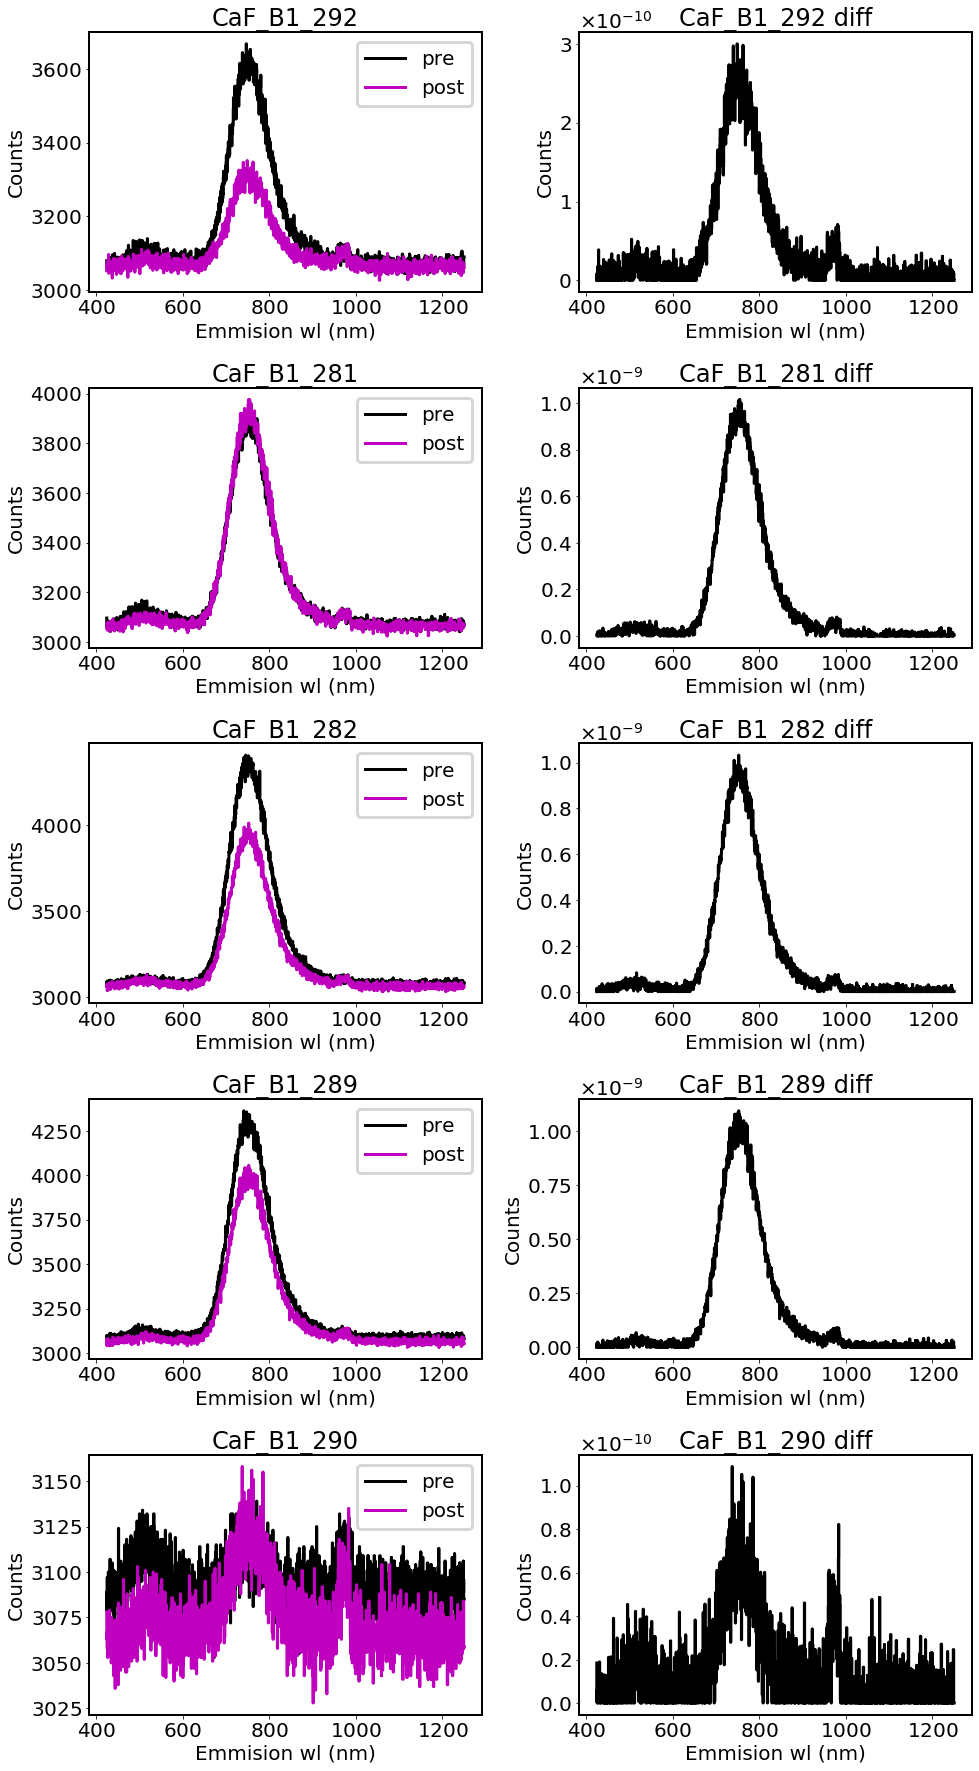

In [59]:
plot_exwl(caf_pre2, caf_post2, 410, (1200, 1250))

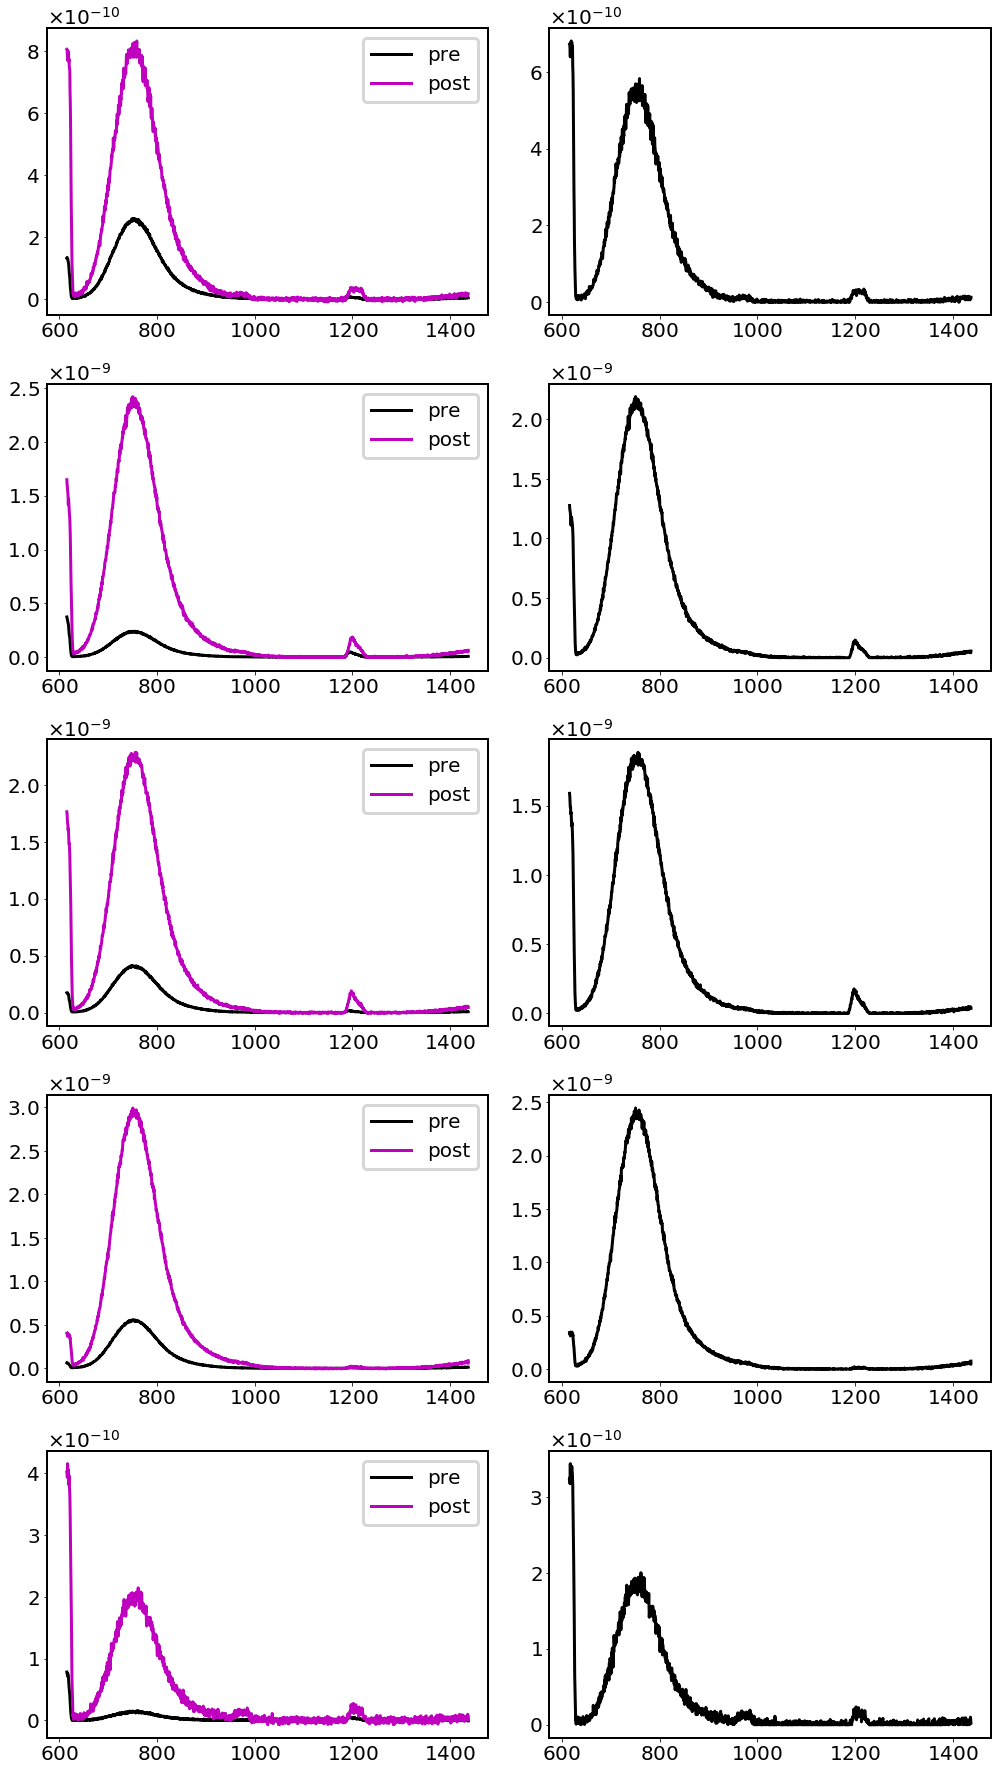

In [44]:
plot_exwl(caf_pre2, caf_post2, 600, (1100, 1150))

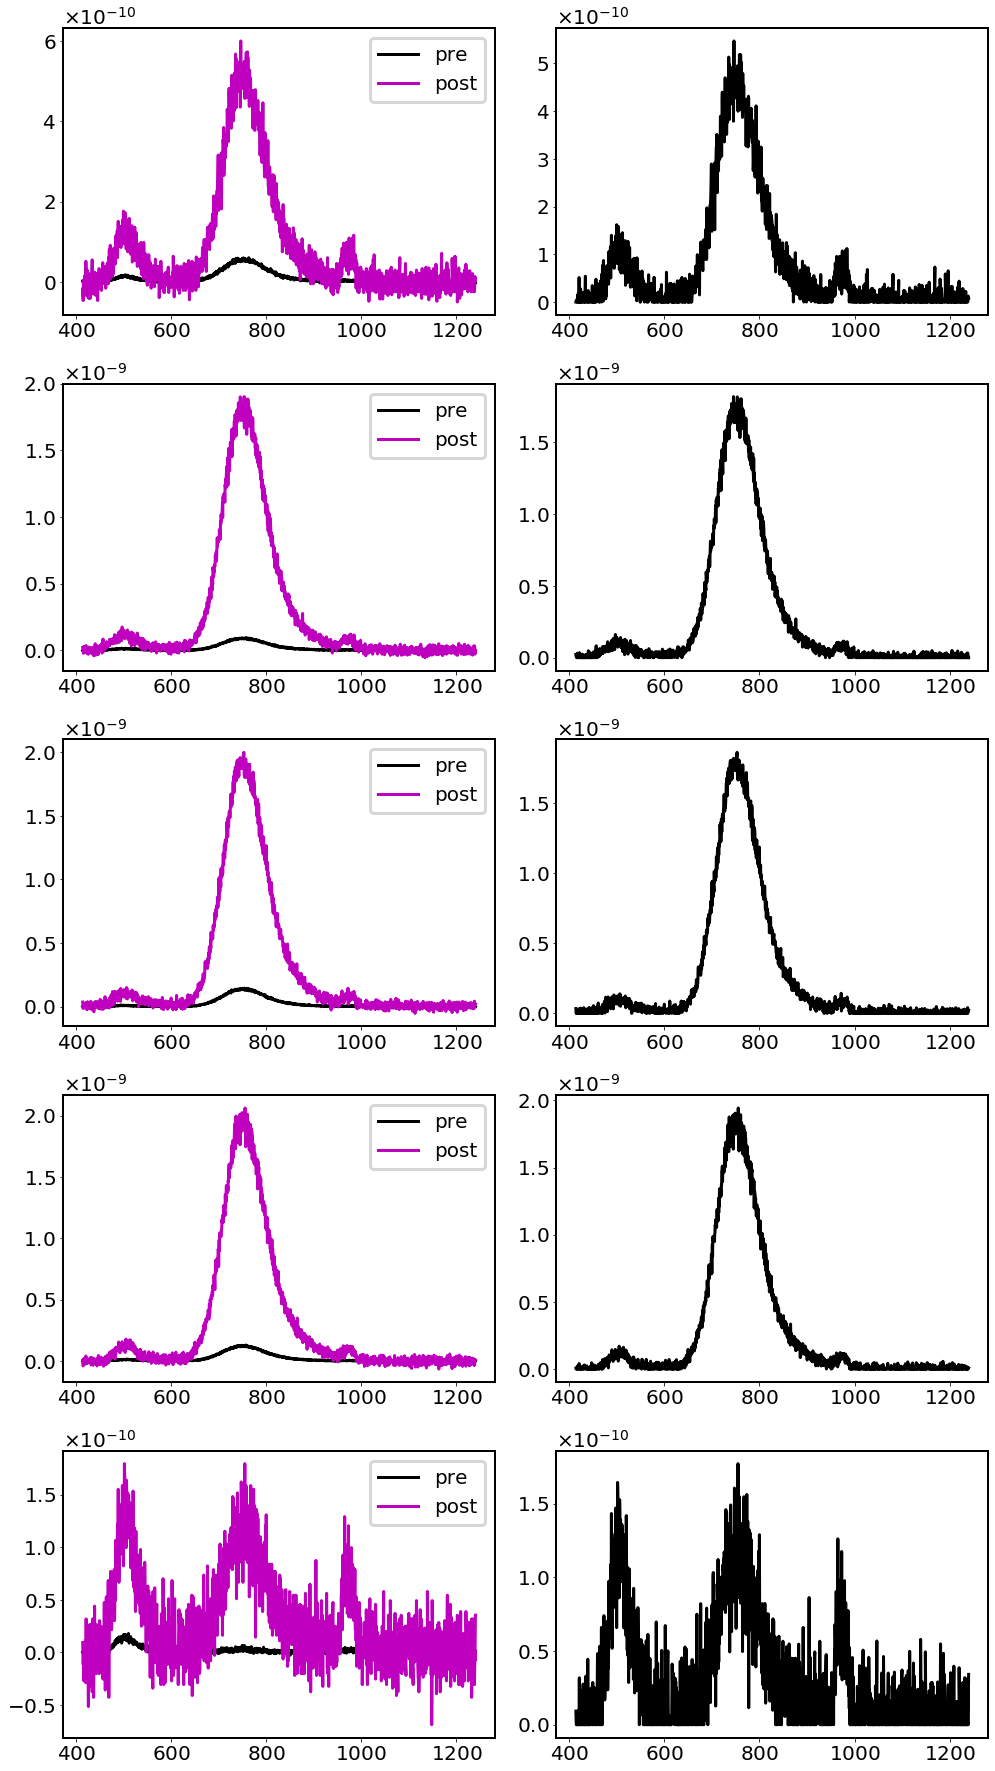

In [45]:
plot_exwl(caf_pre2, caf_post2, 400, (1150, 1200))

RuntimeError: Empty DataFrame

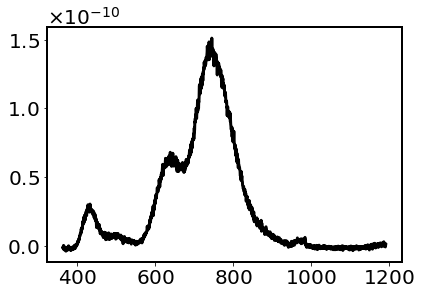

In [46]:
plot_exwl(caf_pre, caf_post, 350, (1150, 1200))